## Import statements and load data

In [1]:
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.cm as cm
import cartopy.crs as ccrs

from matplotlib import animation
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.collections import LineCollection
from cartopy.io.img_tiles import MapboxTiles

%matplotlib inline

We filter into two different datasets, the first one pickups originating from
`RECT`, grouped by pickup times, and the second dropoffs into `RECT`, grouped by
dropoff times.

In [2]:
INPUT_FILE = '../data/trip_data_1_full.csv'
DATETIME_FORMAT = '%Y-%m-%d %H:%M:%S'

# Bounding box for location-based filtering
LAT_MIN, LAT_MAX = 40.76041, 40.76507
LON_MIN, LON_MAX = -73.98164, -73.97653
RECT = [LON_MIN, LON_MAX, LAT_MIN, LAT_MAX]

def filter_df(df, rect, dir='pickup'):
    ''' Filters a dataframe object based on location
    '''
    df = df[(df['{}_longitude'.format(dir)] >= rect[0]) &
            (df['{}_longitude'.format(dir)] <= rect[1]) &
            (df['{}_latitude'.format(dir)]  >= rect[2]) &
            (df['{}_latitude'.format(dir)]  <= rect[3])]
    return df

# Load and filter data without reading entire csv at once
tds_p, tds_d = [],[]
data_iterator = pd.read_csv(INPUT_FILE, iterator=True, chunksize=10000)
for df in data_iterator:
    tds_p.append(filter_df(df, RECT, 'pickup'))
    tds_d.append(filter_df(df, RECT, 'dropoff'))
    
td_p = pd.concat(tds_p, ignore_index=True)
td_d = pd.concat(tds_d, ignore_index=True)

print 'Pickup data size: {}, Dropoff data size: {}'.format(len(td_p), len(td_d))

Pickup data size: 188392, Dropoff data size: 190378


For each dataset, we cutoff outlier times, convert pickup and dropoff times to
datetime objects, then create an index on the pickup/dropoff times. Finally we
group them into buckets (number determined by `NFRAMES` variable) according to
their pickup/dropoff times.

In [3]:
# Trips taking longer than this amount (in seconds) will be filtered off
TRIP_TIME_CUTOFF = 1500
# Number of time slices to split a day into
NFRAMES = 24

def process_times(d, dir):
    # Cut off long tail
    d = d[d['trip_time_in_secs'] < TRIP_TIME_CUTOFF]

    # Convert to datetime objects
    d['pickup_datetime'] = pd.to_datetime(d['pickup_datetime'])
    d['dropoff_datetime'] = pd.to_datetime(d['dropoff_datetime'])

    # Create datetime index
    d = d.set_index(pd.DatetimeIndex(d[dir + '_datetime']))
    return d

td_p = process_times(td_p, 'pickup')
td_d = process_times(td_d, 'dropoff')

# Computes time intervals for grouping by time
starts = [dt.time(x / 60, x % 60) for x in range(0, 1440, 1440 / NFRAMES)]
ends = starts[1:] + [starts[0]]

# Group into NFRAMES number of pickup/dropoff time intervals
trips_p = [td_p.between_time(s, e) for s, e in zip(starts, ends)]
trips_d = [td_d.between_time(s, e) for s, e in zip(starts, ends)]

/usr/lib/python2.7/site-packages/IPython/kernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/lib/python2.7/site-packages/IPython/kernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## Plot pickup trip time histogram

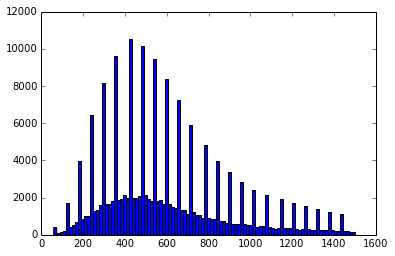

In [4]:
pickup_trip_times = np.asarray(td_p['trip_time_in_secs'], dtype=np.int)
plt.hist(pickup_trip_times, bins=100)
plt.show() 

## Plots trips against pickup time

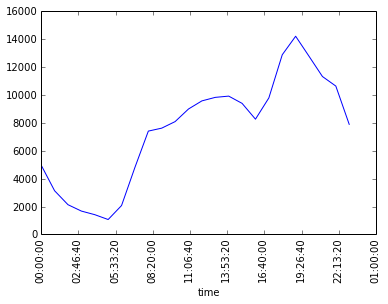

In [5]:
plt.plot(starts, map(len, trips_p))
plt.xticks(rotation='vertical')
plt.show()

## Plot a map color-coding with trip times 

In [4]:
# Add a map using a mapbox template
mapbox_token = 'pk.eyJ1IjoiY2hlbnlhbmciLCJhIjoiNjAwYTI1MDExNDdmYzVkZWY0M2NkNjQyMDJkZjhkOTMifQ.G7P8sFypgRqFW2QNaEZocQ'
mapbox_mapid = 'chenyang.e39eae3e'
mapbox_tiles = MapboxTiles(mapbox_token, mapbox_mapid)
manhattan_rect = [-74.025, -73.92, 40.70, 40.85]

# Use pickup times
trips = trips_p

def draw_frame(frame_no=None):
    # Create new axes, using the tiles' projection for the underlying map.
    plt.clf()
    ax = plt.axes(projection=mapbox_tiles.crs)
    
    # Load data for current frame
    data = td if frame_no is None else trips[frame_no]
    
    dropoff_lat = np.asarray(data['dropoff_latitude'], dtype=np.float)
    dropoff_lon = np.asarray(data['dropoff_longitude'], dtype=np.float)
    trip_time = np.asarray(data['trip_time_in_secs'], dtype=np.int)
        
    # Add the tiles at zoom level 13.
    ax.add_image(mapbox_tiles, 13)
    
    # Specify a region of interest, in this case, Manhattan.
    ax.set_extent(manhattan_rect, ccrs.PlateCarree())

    # Plot the origin area
    ax.add_patch(Rectangle((LON_MIN, LAT_MIN), LON_MAX-LON_MIN, LAT_MAX-LAT_MIN, 
                 facecolor="blue", alpha=0.3, lw=0,
                 transform=ccrs.PlateCarree()))
    
    # Plot destinations, color coded by travel times
    sc = ax.scatter(dropoff_lon, dropoff_lat, 
                    marker='.', s=15, lw=0, 
                    c=trip_time, cmap=cm.RdYlGn_r, vmin=0, vmax=TRIP_TIME_CUTOFF,
                    transform=ccrs.PlateCarree())
        
    # Scale and labels
    cur_time = starts[frame_no] if frame_no != None else 'All'
    plt.title('Dropoff Locations at Time: {}'.format(cur_time))
    plt.colorbar(sc).set_label('Trip time in seconds')

## Render and save animation

In [ ]:
plt.clf()
fig = plt.figure(figsize=(16, 16))
anim = animation.FuncAnimation(fig, draw_frame, frames=NFRAMES)
anim.save('animation.gif', writer='imagemagick', fps=4)

## Plot for all trips

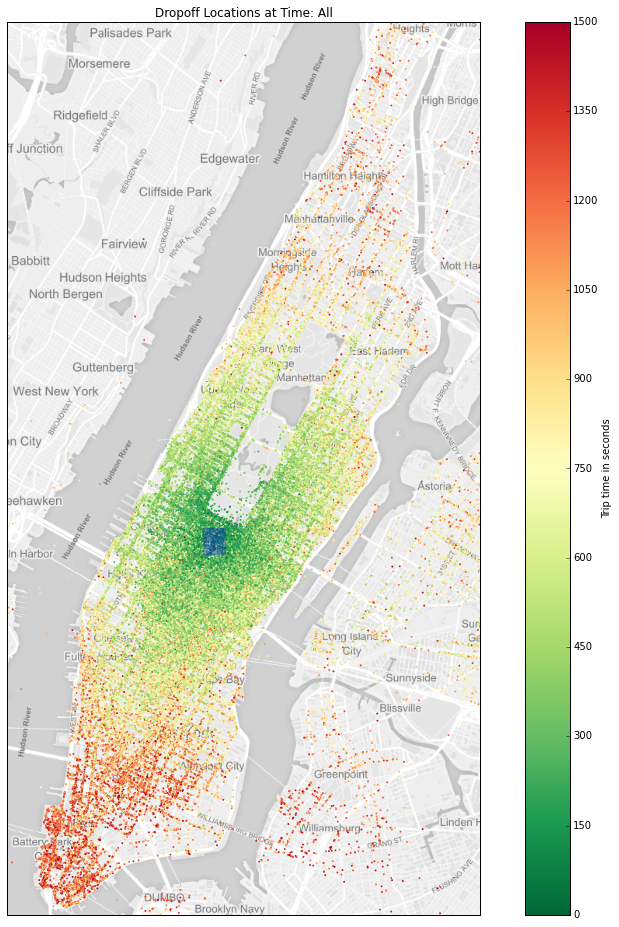

In [7]:
fig = plt.figure(figsize=(16, 16))
draw_frame()

## OSRM Pathfinder Setup

In [5]:
import requests
from polyline.codec import PolylineCodec

OSRM_SERVER = 'http://127.0.0.1:5000'

def decode(geom):
    ''' Polyline library returns 6 decimal places, so we divide each coord
    by 10 here
    '''
    return [(x / 10, y / 10) for x, y in PolylineCodec().decode(geom)]

def osrm_pathfinder(row):
    '''Returns a path, which is a series of links'''
    plat, plon = row['pickup_latitude'], row['pickup_longitude']
    dlat, dlon = row['dropoff_latitude'], row['dropoff_longitude']
    
    url = '{}/viaroute?loc={},{}&loc={},{}'.format(OSRM_SERVER, plat, plon, dlat, dlon)
    res = requests.get(url).json()
    if 'route_geometry' not in res:
        print res
    return decode(res['route_geometry'])

# Setup path inference filter

In [25]:
import sys
import os
sys.path.append(os.path.abspath("../../expose_data/python_wksp"))

from CoreGraph.OSMGraph import OSMGraph
from CoreGraph.CythonCore._CoreGraph import *

## Upload data to mongodb if necessary

In [ ]:
!mkdir -p ~/mongod
!export PYTHONPATH=~/src/megacell/expose_data/python_wksp/:$PYTHONPATH && cd ../OSM/scripts; python2 upload_xml_to_mongo.py ~/src/megacell/traffic_data/central_new-york.osm.xml central_ny

In [7]:
ny_graph = OSMGraph('central_ny')

In [50]:
def create_spatial_projector(graph):
    vertex_coord_dict = dict(zip(graph.vertex_ids, graph.vertex_coords))
    source_coords = np.asarray([vertex_coord_dict[i] for i in graph.source_ids], dtype = 'f8,f8')
    target_coords = np.asarray([vertex_coord_dict[i] for i in graph.target_ids], dtype = 'f8,f8')
    return Projector(graph.vertex_ids, graph.vertex_coords, graph.source_ids,
                     source_coords, graph.target_ids, target_coords)

def flatten(lst):
    '''
    >>> flatten([[1], [2, 3, [4]], 5])
    [1, 2, 3, 4, 5]
    '''
    res = []
    for item in lst:
        if type(item) == list:
            res.extend(flatten(item))
        else:
            res.append(item)
    return res

max_projs = 3     # maximum number of projections allowed
max_paths = 1     # maximum number of paths between projections
gps_pen   = 1.0   # penalization coefficient of distance from GPS trace to network
path_pen  = 10.0  # penalization coefficient of length of path between projections

graph = ny_graph
bst = BoundedKShortest(graph)
projector = create_spatial_projector(graph)
pif = PathInferenceFilter(graph, bst, projector,
                          max_projs, max_paths, gps_pen, path_pen)

ip = TrajectoryInterp(graph)

def pif_pathfinder(row, link_ids=False):
    '''Returns a series of link-ids if LINK_IDS is true, else return a series of
    coordinates
    '''
    plat, plon = row['pickup_latitude'], row['pickup_longitude']
    dlat, dlon = row['dropoff_latitude'], row['dropoff_longitude']
    max_dist = row['trip_time_in_secs'] * 40 # conservative overestimate of 40m/s
    thresholds = [max_dist] * 2 # highest cost allowed between consecutive points
    
    GPS_locations = [(plon, plat), (dlon, dlat)]
    _, path = pif.run(GPS_locations, thresholds)
    path = [p for p in flatten(path) if p in graph.vertex_coord_dict]
    coords = [graph.vertex_coord_dict[p] for p in path]
    return path if link_ids else coords

In [ ]:
ip.interpolate([],20)

ValueError: need more than 0 values to unpack

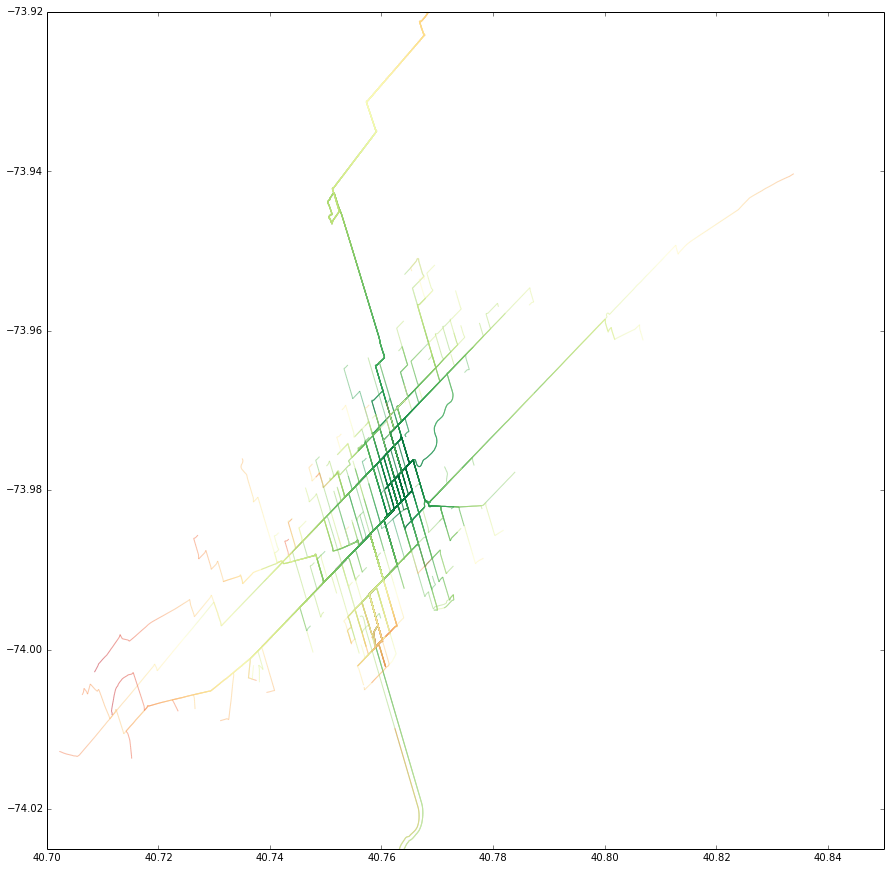

In [51]:
plt.figure(figsize=(15, 15))
norm = plt.Normalize(0.0, 1.0)
ax = plt.gca()
#ax = plt.axes(projection=mapbox_tiles.crs)

plt.xlim(manhattan_rect[2:])
plt.ylim(manhattan_rect[:2])

# Specify a region of interest, in this case, Manhattan.
#ax.set_extent(manhattan_rect, mapbox_tiles.crs)

# Add the tiles at zoom level 13.
#ax.add_image(mapbox_tiles, 13)

def make_segments(x, y):
    '''Create list of line segments from x and y coordinates, in the correct
    format for LineCollection: an array of the form:
    numlines x (points per line) x 2 (x and y) array
    '''
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    return np.concatenate([points[:-1], points[1:]], axis=1)


# 8am-9am pickups
trips_to_plot = list(trips_p[8].iterrows())

failed = 0
for _, row in trips_to_plot:
    path = pif_pathfinder(row, link_ids=True)
    if len(path) == 0:
        failed += 1
        continue
    y, x = zip(*ip.interpolate(path, 20))
    z = np.linspace(0.0, row['trip_time_in_secs']/1500.0, len(x))
    lc = LineCollection(make_segments(x, y), array=z, cmap=cm.RdYlGn_r, norm=norm, alpha=0.5)
    # lc.set_transform(mapbox_tiles.crs)
    ax.add_collection(lc)

print 'Total trips: {}, Failed trips: {}'.format(len(trips_to_plot), failed)

plt.show()
